<a href='https://honglab.ai'><p style="text-align:center;"><img src='https://lh3.googleusercontent.com/lY3ySXooSmwsq5r-mRi7uiypbo0Vez6pmNoQxMFhl9fmZJkRHu5lO2vo7se_0YOzgmDyJif9fi4_z0o3ZFdwd8NVSWG6Ea80uWaf3pOHpR4GHGDV7kaFeuHR3yAjIJjDgfXMxsvw=w2400'  class="center" width="100%" height="100%"/></p></a>

<center><em>Content Copyright by HongLab, Inc.</em></center>

#  미분 가능한 렌더링(Differentiable Rendering) - 가우시안 스플랫


## 2D 가우시안 함수와 공분산 행렬

A 2D Gaussian splat is parameterized by:
- **Position** $\boldsymbol{\mu} = [\mu_x, \mu_y]^T$ — the center location in 2D space
- **Scales** $\boldsymbol{\sigma} = [\sigma_x, \sigma_y]^T$ — the width and height (must be positive)
- **Rotation** $\theta$ — the orientation angle (radians)

> Coordinate convention (matches the code): positions $\mathbf{p}$ and centers $\boldsymbol{\mu}$ live in **normalized device coordinates** (NDC) in $[-1, 1]\times[-1, 1]$, with $y$ pointing up.

The Gaussian kernel value at point $\mathbf{p}$ is:

$$
f(\mathbf{p}) = \exp\left(
  -\frac{1}{2} 
  (\mathbf{p} - \boldsymbol{\mu})^T 
  \Sigma^{-1}
  (\mathbf{p} - \boldsymbol{\mu})
\right)
$$

where $\Sigma$ is the **covariance matrix** that describes the shape and orientation.

> Note: In this notebook we use $f(\mathbf{p})$ as a **splat kernel** (unnormalized Gaussian). We omit the PDF normalization constant since the overall amplitude can be absorbed into opacity/color during optimization.

### 공분산 행렬 $\Sigma$ 만들기

We construct $\Sigma$ from rotation and scale.

Let $R(\theta)$ be the 2D rotation matrix:

$$
R(\theta) = \begin{bmatrix}
\cos \theta & -\sin\theta\\
\sin \theta & \cos \theta
\end{bmatrix}
$$

and let $S$ be the diagonal scaling matrix:

$$
S = \begin{bmatrix}
\sigma_x & 0 \\
0 & \sigma_y
\end{bmatrix}
$$

Then:

$$
\Sigma = R(\theta)\, S S^T\, R(\theta)^T
$$

Since $S$ is diagonal, $SS^T = \mathrm{diag}(\sigma_x^2,\,\sigma_y^2)$.

### 공분산 행렬의 역행렬

Because $R(\theta)$ is orthonormal ($R^{-1} = R^T$), we get:

$$
\Sigma^{-1} = R(\theta)\,(SS^{T})^{-1}\,R(\theta)^T
= R(\theta)
\begin{bmatrix}
\frac{1}{\sigma_x^2} & 0 \\
0 & \frac{1}{\sigma_y^2}
\end{bmatrix}
R(\theta)^T
$$

> Implementation note (matches the code): we clamp $\boldsymbol{\sigma}$ to a small positive minimum to avoid division by zero when building $\Sigma^{-1}$.

### 훈련 가능한 매개변수들

Each 2D Gaussian splat is defined by **9 trainable parameters**:

1. **Position** $\boldsymbol{\mu} = [\mu_x, \mu_y]^T \in \mathbb{R}^2$ — center location (2 parameters)
2. **Scale** $\boldsymbol{\sigma} = [\sigma_x, \sigma_y]^T \in \mathbb{R}^2$ — width and height (2 parameters)
3. **Rotation** $\theta \in \mathbb{R}$ — orientation angle in radians (1 parameter)
4. **Opacity** $\alpha \in [0, 1]$ — transparency/opacity scalar (1 parameter)
5. **Color** $\text{rgb} = [r, g, b]^T \in [0, 1]^3$ — RGB color vector (3 parameters)

**가우시안 하나당 9개의 매개변수들**

During optimization, PyTorch's autograd computes gradients $\nabla_{\Theta} \mathcal{L}$ with respect to the full parameter set $\Theta=(\boldsymbol{\mu},\boldsymbol{\sigma},\theta,\alpha,\text{rgb})$:
- $\nabla_{\boldsymbol{\mu}} \mathcal{L}$ — move Gaussians to better positions
- $\nabla_{\boldsymbol{\sigma}} \mathcal{L}$ — adjust size to cover features
- $\nabla_{\theta} \mathcal{L}$ — rotate to align with oriented edges
- $\nabla_{\alpha} \mathcal{L}$ — control opacity/transparency
- $\nabla_{\text{rgb}} \mathcal{L}$ — match target colors

This works because Gaussian kernels are **smooth and differentiable everywhere**, unlike hard-edged primitives.

### 가산 혼합 렌더링 (Additive Blending Rendering)

We reconstruct each pixel $\mathbf{p}$ by summing contributions from all $N$ Gaussians with **additive blending**:

$$
I(\mathbf{p}) = \sum_{i=1}^{N} \alpha_i \cdot \text{rgb}_i \cdot f_i(\mathbf{p}; \boldsymbol{\mu}_i, \Sigma_i)
$$

where:
- $f_i(\mathbf{p}; \boldsymbol{\mu}_i, \Sigma_i)$ is the Gaussian kernel using the full 2×2 covariance matrix $\Sigma_i$
- $\alpha_i \in [0, 1]$ is the opacity scalar controlling transparency
- $\text{rgb}_i = [r, g, b]^T \in [0, 1]^3$ is the RGB color vector

**Key properties**:
- Each Gaussian can be independently rotated via $\theta_i$
- Opacity and color are optimized separately, allowing independent control
- Smooth, differentiable everywhere → excellent for gradient-based optimization
- This notebook uses **additive accumulation** (sum + clamp). Full 3D Gaussian Splatting typically uses **depth-sorted alpha compositing** in screen space, which is a different blending model.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import Video

# Figure defaults
plt.rcParams["figure.dpi"] = 120
plt.rcParams["savefig.dpi"] = 120

def make_pixel_grid(H, W, device='cpu'):
    """Create pixel centers in normalized device coords [-1, 1] with y pointing up"""
    xs = (torch.arange(W, device=device) + 0.5) / W * 2 - 1
    ys = (torch.arange(H, device=device) + 0.5) / H * 2 - 1
    Y, X = torch.meshgrid(ys, xs, indexing='ij')
    Y = torch.flip(Y, dims=[0])
    P = torch.stack([X, Y], dim=-1)  # (H, W, 2)
    return P

def render_gaussians_2d(H, W, mus, sigmas, thetas, opacities, rgbs):
    """Render multiple 2D Gaussian splats using full covariance matrices.
    
    Args:
        H, W: image dimensions
        mus: (N, 2) center positions μ
        sigmas: (N, 2) scale parameters σ
        thetas: (N,) rotation angles θ in radians
        opacities: (N,) opacity scalars α in [0, 1]
        rgbs: (N, 3) RGB color vectors
    
    Returns:
        img: (H, W, 3) rendered image
    
    Full covariance formulation: I(p) = Σ(i=1 to N) α_i * rgb_i * f_i(p; μ_i, Σ_i)
    where f_i uses 2×2 covariance matrix with rotation.
    """
    device = mus.device
    P = make_pixel_grid(H, W, device=device)  # (H, W, 2)
    
    img = torch.zeros((H, W, 3), device=device, dtype=mus.dtype)
        
    # Additive blending: sum all Gaussian contributions
    for i in range(len(mus)):
        mu = mus[i]
        sigma = sigmas[i]
        theta = thetas[i]
        opacity = opacities[i]
        rgb = rgbs[i]
        
        # Build inverse covariance matrix inline (formerly build_sigma_inv)
        TODO
        
        # Compute Gaussian function f_i(p) with full covariance
        TODO

        # Accumulate: I(p) += α_i * rgb_i * f_i(p)
        TODO
    
    img = torch.clamp(img, 0.0, 1.0)
    return img

def show_images(images, titles, figsize=None, vmin=0.0, vmax=1.0):
    n = len(images)
    if figsize is None:
        figsize = (3.6 * n, 3.6)
    fig, axes = plt.subplots(1, n, figsize=figsize)
    if n == 1:
        axes = [axes]
    for ax, im, title in zip(axes, images, titles):
        if torch.is_tensor(im):
            im = im.detach().cpu().numpy()
        ax.imshow(im, vmin=vmin, vmax=vmax, interpolation="nearest")
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def show_image_grid(images, titles, cols=4, cell_size=3.2, vmin=0.0, vmax=1.0):
    n = len(images)
    cols = int(max(1, cols))
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cell_size * cols, cell_size * rows))
    axes = np.array(axes).reshape(rows, cols)
    for i in range(rows * cols):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        if i < n:
            im = images[i]
            if torch.is_tensor(im):
                im = im.detach().cpu().numpy()
            ax.imshow(im, vmin=vmin, vmax=vmax, interpolation="nearest")
            ax.set_title(titles[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def diff_image(a, b):
    """Compute pixel-wise absolute difference"""
    d = torch.abs(a - b)
    mag = torch.clamp(torch.norm(d, dim=-1, keepdim=True) / np.sqrt(3.0), 0.0, 1.0)
    return d, mag.repeat(1, 1, 3)

def save_training_video(frames, filename, fps=30, title="Training Progress"):
    """Save list of image frames as MP4 video."""
    if len(frames) == 0:
        print(f"No frames to save for {filename}")
        return
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title(title)
    ax.axis('off')
    
    im_display = ax.imshow(frames[0], vmin=0.0, vmax=1.0, interpolation="nearest")
    text = ax.text(0.5, -0.05, f"Iteration: 0", transform=ax.transAxes, 
                   ha='center', fontsize=12)
    
    def update(frame_idx):
        im_display.set_array(frames[frame_idx])
        text.set_text(f"Iteration: {frame_idx}")
        return [im_display, text]
    
    anim = FuncAnimation(fig, update, frames=len(frames), interval=1000/fps, blit=True)
    writer = FFMpegWriter(fps=fps, bitrate=1800)
    anim.save(filename, writer=writer)

    plt.close(fig)    
    print(f"Video saved to {filename}")

def draw_gaussian_ellipses(ax, mus, sigmas, thetas, color='yellow', label='Gaussians', 
                          sigma_scale=3.0, show_centers=True, alpha=0.7, linewidth=2):
    """Draw nσ ellipse boundaries for Gaussian parameters.
    
    Args:
        ax: matplotlib axis to draw on
        mus: (N, 2) center positions μ (or (2,) for single Gaussian)
        sigmas: (N, 2) scale parameters σ (or (2,) for single Gaussian)
        thetas: (N,) rotation angles θ in radians (or scalar for single Gaussian)
        color: edge color for ellipses and center markers
        label: legend label (only applied to first element)
        sigma_scale: multiplier for ellipse size (default 3.0 for 3σ boundary)
        show_centers: whether to draw center markers
        alpha: transparency of ellipses
        linewidth: line width of ellipse boundaries
    
    The 3σ boundary represents where ~99% of the Gaussian's mass is contained,
    effectively showing the Gaussian's "support" in the image.
    """
    from matplotlib.patches import Ellipse
    
    # Convert to numpy if needed
    if torch.is_tensor(mus):
        mus = mus.detach().cpu().numpy()
    if torch.is_tensor(sigmas):
        sigmas = sigmas.detach().cpu().numpy()
    if torch.is_tensor(thetas):
        thetas = thetas.detach().cpu().numpy()
    
    # Handle single Gaussian (1, 2) or (2,) shape
    if mus.ndim == 2 and mus.shape[0] == 1:
        mus = mus[0]
        sigmas = sigmas[0]
        thetas = thetas[0:1]
    
    # Ensure arrays are 2D for iteration
    if mus.ndim == 1:
        mus = mus.reshape(1, -1)
        sigmas = sigmas.reshape(1, -1)
        thetas = np.atleast_1d(thetas)
    
    # Draw centers if requested
    if show_centers:
        ax.scatter(mus[:, 0], mus[:, 1], c=color, s=80, marker='x', 
                  linewidths=2, label=label if label else None, zorder=100)
    
    # Draw ellipses
    for i in range(len(mus)):
        ellipse = Ellipse(
            (mus[i, 0], mus[i, 1]),
            width=sigmas[i, 0] * sigma_scale,
            height=sigmas[i, 1] * sigma_scale,
            angle=np.degrees(thetas[i]),
            edgecolor=color,
            facecolor='none',
            linewidth=linewidth,
            alpha=alpha,
            label=label if (i == 0 and not show_centers) else None,
            zorder=99
        )
        ax.add_patch(ellipse)

## Example 1 — Single Gaussian Splat Fitting

**Problem**: Optimize Gaussian parameters $\Theta = (\boldsymbol{\mu}, \boldsymbol{\sigma}, \theta, \alpha, \text{rgb})$ where:
- $\boldsymbol{\mu} \in \mathbb{R}^{2}$ is the center position (in NDC, $[-1,1]^2$)
- $\boldsymbol{\sigma} \in \mathbb{R}^{2}$ are the scale parameters (width, height; positive)
- $\theta \in \mathbb{R}$ is the rotation angle (radians)
- $\alpha \in [0, 1]$ is the opacity (transparency control)
- $\text{rgb} \in [0, 1]^{3}$ is the RGB color vector

**Objective**: Minimize MSE between rendered and target images:

$$
\mathcal{L}(\Theta) = \frac{1}{HW}\sum_{i,j} \| \hat I_{\Theta}(i,j) - I^*(i,j) \|_2^2
$$

Here $\hat I_{\Theta}(i,j)\in\mathbb{R}^3$ is the rendered RGB at pixel $(i,j)$.

**Gaussian rendering with full covariance**:

For a pixel at position $\mathbf{p}$, using the 2×2 covariance matrix:

$$
f(\mathbf{p}; \boldsymbol{\mu}, \Sigma) = \exp\left(-\frac{1}{2}(\mathbf{p} - \boldsymbol{\mu})^T \Sigma^{-1} (\mathbf{p} - \boldsymbol{\mu})\right)
$$

We build the inverse covariance exactly as in the code:

$$
\Sigma^{-1} = R(\theta)\,\mathrm{diag}(1/\sigma_x^2,\,1/\sigma_y^2)\,R(\theta)^T
$$

with $S = \begin{bmatrix}\sigma_x & 0 \\ 0 & \sigma_y\end{bmatrix}$ and $SS^T=\mathrm{diag}(\sigma_x^2,\sigma_y^2)$.

Single Gaussian (additive model):

$$
\hat I_{\Theta}(\mathbf{p}) = \alpha \cdot \text{rgb} \cdot f(\mathbf{p}; \boldsymbol{\mu}, \Sigma)
$$

For multiple Gaussians:

$$
\hat I(\mathbf{p}) = \sum_{i=1}^{N} \alpha_i \cdot \text{rgb}_i \cdot f_i(\mathbf{p}; \boldsymbol{\mu}_i, \Sigma_i)
$$

**Key advantages**:
- Full covariance matrix allows rotated elliptical Gaussians
- Separate opacity and color enables independent control
- Smooth and differentiable everywhere for excellent gradient-based optimization

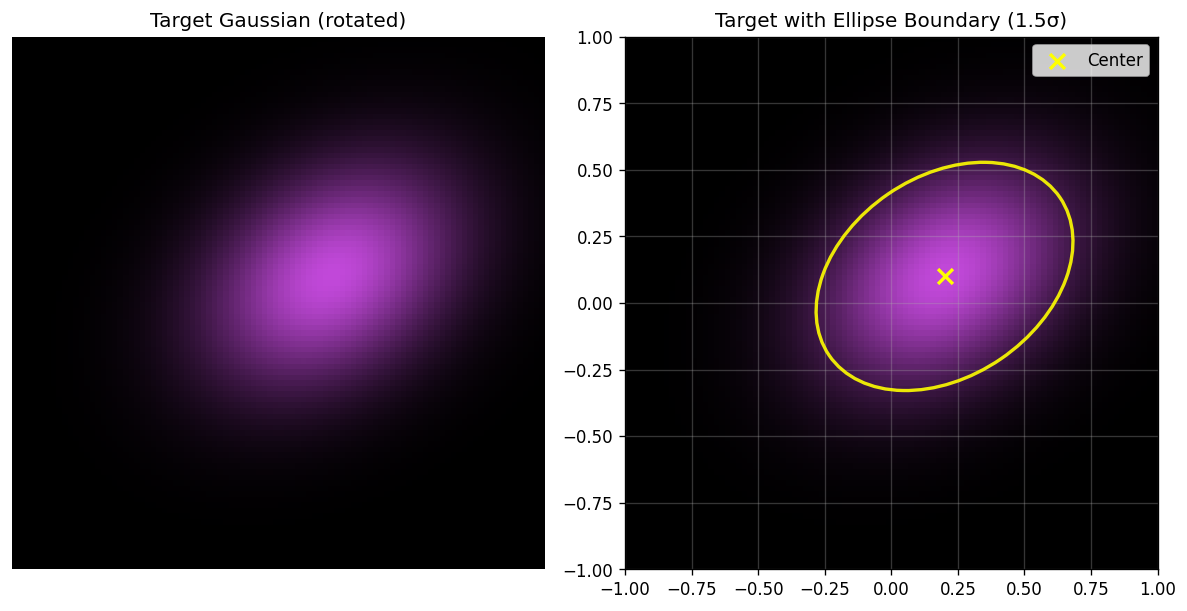

In [2]:
# Scene setup
H, W = 96, 96

# Target: a single rotated Gaussian with purple color
# Use batched format (1, k) for consistency with render_gaussians_2d
target_mu = torch.tensor([[0.2, 0.1]], dtype=torch.float32)  # (1, 2)
target_sigma = torch.tensor([[0.35, 0.25]], dtype=torch.float32)  # (1, 2)
target_theta = torch.tensor([0.6], dtype=torch.float32)  # (1,) ~34 degrees rotation
target_opacity = torch.tensor([0.95], dtype=torch.float32)  # (1,) opacity
target_rgb = torch.tensor([[0.8, 0.3, 0.9]], dtype=torch.float32)  # (1, 3) Purple RGB

img_target_g = render_gaussians_2d(H, W, target_mu, target_sigma, target_theta, target_opacity, target_rgb)

# Visualize with and without ellipse boundary
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Left: plain target image
ax1.imshow(img_target_g.detach().cpu().numpy(), interpolation="nearest")
ax1.set_title("Target Gaussian (rotated)")
ax1.axis('off')

# Right: target with ellipse boundary
ax2.imshow(img_target_g.detach().cpu().numpy(), extent=[-1, 1, -1, 1], origin='upper', interpolation="nearest")
draw_gaussian_ellipses(ax2, target_mu, target_sigma, target_theta, 
                       color='yellow', label='Center', alpha=0.9)
ax2.set_xlim(-1, 1)
ax2.set_ylim(-1, 1)
ax2.set_aspect('equal')
ax2.set_title('Target with Ellipse Boundary (1.5σ)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

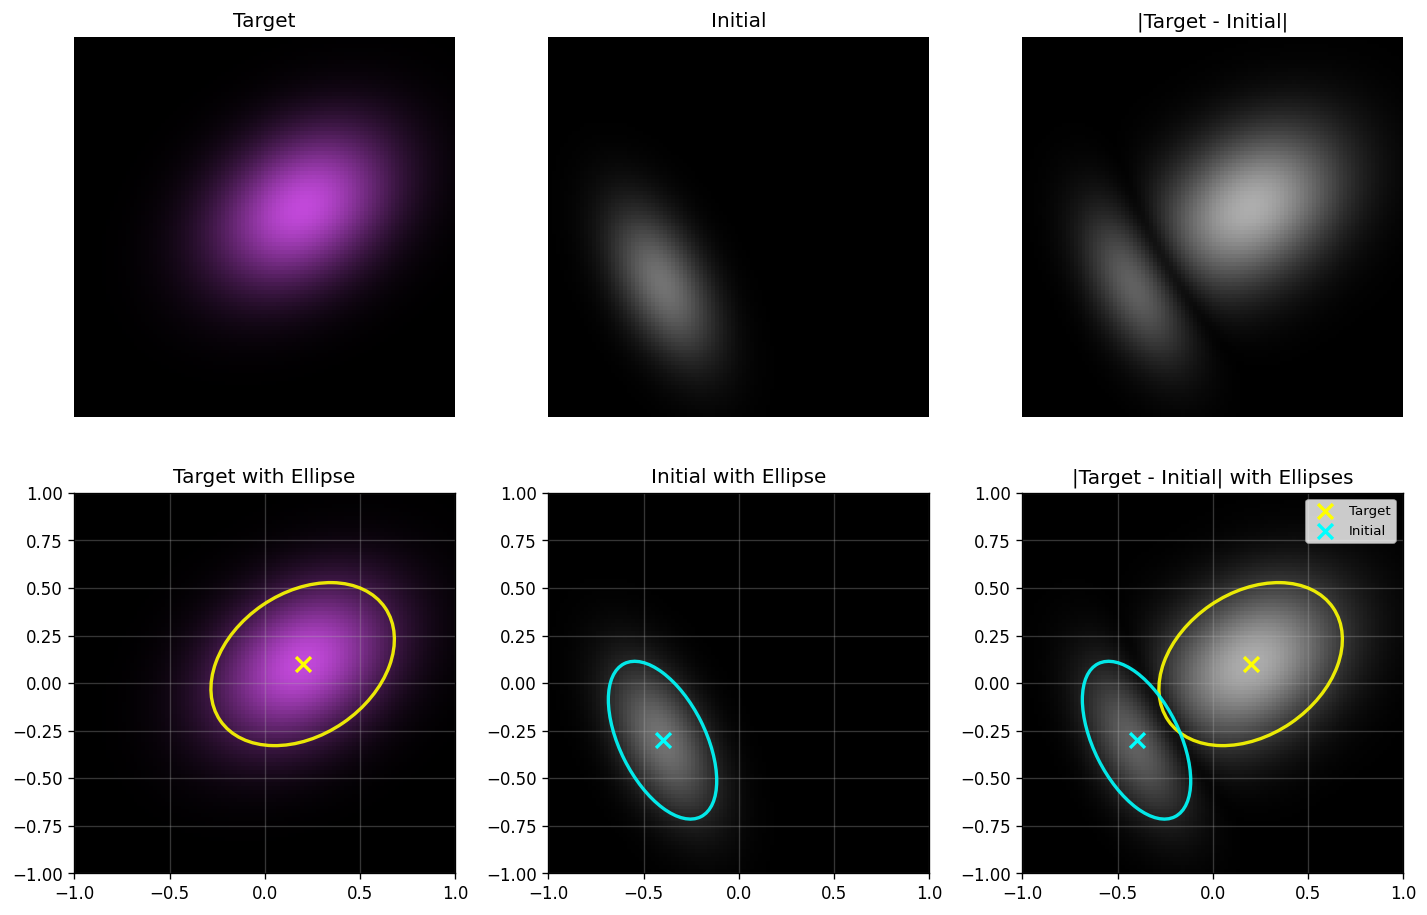

In [3]:
# Initial guess: wrong position, size, rotation, and gray color
# Use batched format (1, k) for consistency with render_gaussians_2d
init_mu = torch.tensor([[-0.4, -0.3]], dtype=torch.float32)  # (1, 2) position
init_sigma = torch.tensor([[0.3, 0.15]], dtype=torch.float32)  # (1, 2) scaling
init_theta = torch.tensor([90.0], dtype=torch.float32)  # (1,) rotation
init_opacity = torch.tensor([0.9], dtype=torch.float32)  # (1,) opacity
init_rgb = torch.tensor([[0.5, 0.5, 0.5]], dtype=torch.float32)  # (1, 3) Gray RGB

img_init_g = render_gaussians_2d(H, W, init_mu, init_sigma, init_theta, init_opacity, init_rgb)
d_rgb, d_mag = diff_image(img_init_g, img_target_g)

# Create 2x3 grid: top row without ellipses, bottom row with ellipses
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Top row: plain images
axes[0, 0].imshow(img_target_g.detach().cpu().numpy(), interpolation="nearest")
axes[0, 0].set_title("Target")
axes[0, 0].axis('off')

axes[0, 1].imshow(img_init_g.detach().cpu().numpy(), interpolation="nearest")
axes[0, 1].set_title("Initial")
axes[0, 1].axis('off')

axes[0, 2].imshow(d_mag.detach().cpu().numpy(), interpolation="nearest")
axes[0, 2].set_title("|Target - Initial|")
axes[0, 2].axis('off')

# Bottom row: same images with ellipse boundaries
# Target with ellipse
axes[1, 0].imshow(img_target_g.detach().cpu().numpy(), extent=[-1, 1, -1, 1], origin='upper', interpolation="nearest")
draw_gaussian_ellipses(axes[1, 0], target_mu, target_sigma, target_theta, 
                       color='yellow', label=None, alpha=0.9)
axes[1, 0].set_xlim(-1, 1)
axes[1, 0].set_ylim(-1, 1)
axes[1, 0].set_aspect('equal')
axes[1, 0].set_title('Target with Ellipse')
axes[1, 0].grid(True, alpha=0.3)

# Initial with ellipse
axes[1, 1].imshow(img_init_g.detach().cpu().numpy(), extent=[-1, 1, -1, 1], origin='upper', interpolation="nearest")
draw_gaussian_ellipses(axes[1, 1], init_mu, init_sigma, init_theta, 
                       color='cyan', label=None, alpha=0.9)
axes[1, 1].set_xlim(-1, 1)
axes[1, 1].set_ylim(-1, 1)
axes[1, 1].set_aspect('equal')
axes[1, 1].set_title('Initial with Ellipse')
axes[1, 1].grid(True, alpha=0.3)

# Difference with both ellipses overlaid
axes[1, 2].imshow(d_mag.detach().cpu().numpy(), extent=[-1, 1, -1, 1], origin='upper', interpolation="nearest")
draw_gaussian_ellipses(axes[1, 2], target_mu, target_sigma, target_theta, 
                       color='yellow', label='Target', alpha=0.9)
draw_gaussian_ellipses(axes[1, 2], init_mu, init_sigma, init_theta, 
                       color='cyan', label='Initial', alpha=0.9)
axes[1, 2].set_xlim(-1, 1)
axes[1, 2].set_ylim(-1, 1)
axes[1, 2].set_aspect('equal')
axes[1, 2].set_title('|Target - Initial| with Ellipses')
axes[1, 2].legend(loc='upper right', fontsize=8)
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [4]:
# Optimization with PyTorch - now with separate opacity and RGB!
mu_param = init_mu.clone().detach().requires_grad_(True)
sigma_param = init_sigma.clone().detach().requires_grad_(True)
theta_param = init_theta.clone().detach().requires_grad_(True)
opacity_param = init_opacity.clone().detach().requires_grad_(True)
rgb_param = init_rgb.clone().detach().requires_grad_(True)

optimizer_g = torch.optim.Adam([mu_param, sigma_param, theta_param, opacity_param, rgb_param], lr=0.01)

history_g = []
snapshots_g = []
snapshot_schedule_g = {0, 1, 2, 5, 10, 20, 40, 60, 100, 150, 200, 250}

# Video frames
video_frames_g = []
video_sample_rate = 2

# Snapshot initial state
snapshots_g.append((0, mu_param.detach().clone(), sigma_param.detach().clone(),
                    theta_param.detach().clone(), opacity_param.detach().clone(), rgb_param.detach().clone()))
video_frames_g.append(img_init_g.detach().cpu().numpy())

max_iters_g = 250
for it in range(max_iters_g):
    optimizer_g.zero_grad()
    
    # Clamp parameters to valid ranges
    with torch.no_grad():
        mu_param.clamp_(-1.0, 1.0)
        sigma_param.clamp_(0.01, 2.0)
        opacity_param.clamp_(0.0, 1.0)
        rgb_param.clamp_(0.0, 1.0)
        # No clamping for theta - let it rotate freely
    
    # Render and compute loss
    img = render_gaussians_2d(H, W, mu_param, sigma_param, theta_param, opacity_param, rgb_param)
    loss = torch.mean((img - img_target_g) ** 2)
    
    # Backward pass
    loss.backward()
    optimizer_g.step()
    
    # Record history
    history_g.append(loss.item())
    
    # Take snapshots
    if (it + 1) in snapshot_schedule_g:
        snapshots_g.append((it + 1, mu_param.detach().clone(), sigma_param.detach().clone(),
                           theta_param.detach().clone(), opacity_param.detach().clone(), rgb_param.detach().clone()))
    
    # Capture video frames
    if (it + 1) % video_sample_rate == 0:
        frame = render_gaussians_2d(H, W, mu_param, sigma_param, theta_param, opacity_param, rgb_param).detach().cpu().numpy()
        video_frames_g.append(frame)

# Add final frame
final_frame = render_gaussians_2d(H, W, mu_param, sigma_param, theta_param, opacity_param, rgb_param).detach().cpu().numpy()
video_frames_g.append(final_frame)

print(f"Final loss: {history_g[-1]:.6f}")
print(f"Final mu: {mu_param.detach().numpy()}")
print(f"Final sigma: {sigma_param.detach().numpy()}")
print(f"Final theta: {theta_param.detach().numpy()[0]:.4f} rad ({np.degrees(theta_param.detach().numpy()[0]):.1f}°)")
print(f"Final opacity: {opacity_param.detach().numpy()}")
print(f"Final RGB: {rgb_param.detach().numpy()}")

Final loss: 0.000000
Final mu: [[0.20000266 0.10000142]]
Final sigma: [[0.24999803 0.35000014]]
Final theta: 90.1354 rad (5164.4°)
Final opacity: [0.9952076]
Final RGB: [[0.76366335 0.28637418 0.8591201 ]]


In [5]:
# Save and display training video
print(f"Creating video with {len(video_frames_g)} frames...")
save_training_video(video_frames_g, "gaussian_single_training.mp4", fps=30, 
                   title="Single Gaussian Fitting")
Video("gaussian_single_training.mp4", embed=True, width=600)

Creating video with 127 frames...
Video saved to gaussian_single_training.mp4


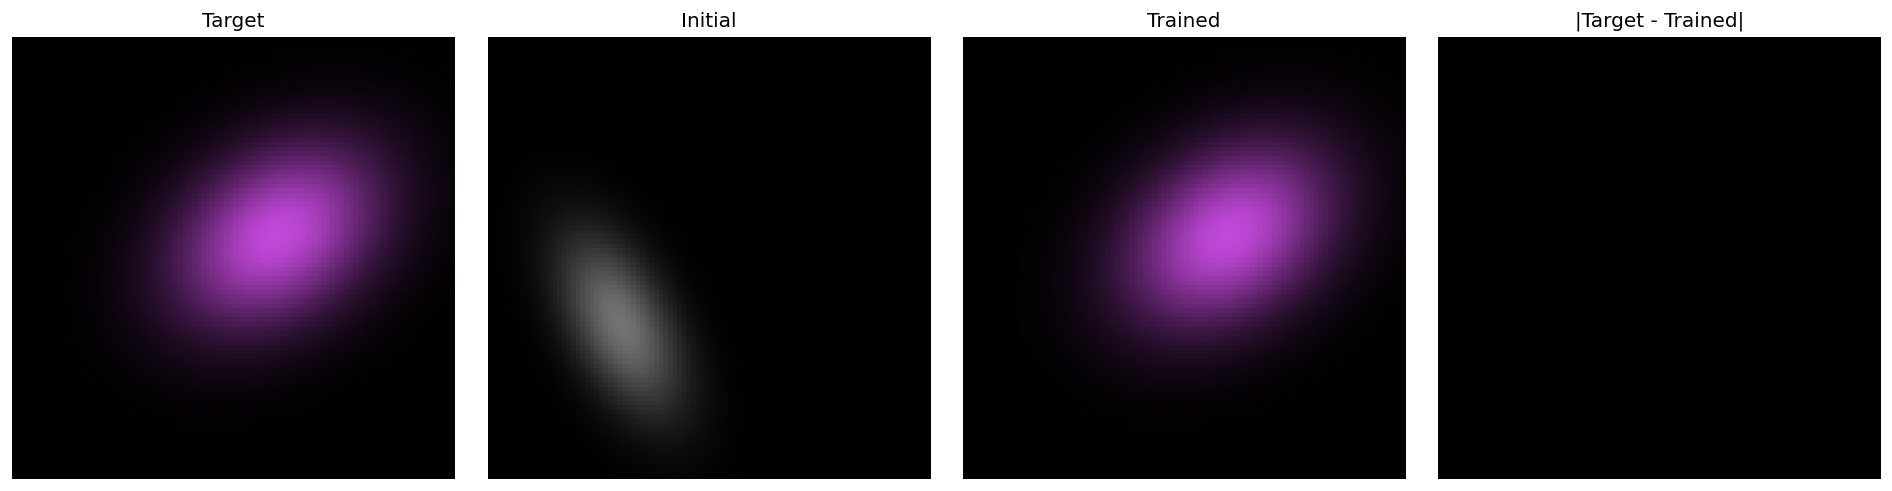

In [6]:
# Final result visualization
img_trained_g = render_gaussians_2d(H, W, mu_param, sigma_param, theta_param, opacity_param, rgb_param)
d_rgb_final, d_mag_final = diff_image(img_target_g, img_trained_g)

show_images(
    [img_target_g, img_init_g, img_trained_g, d_mag_final],
    ["Target", "Initial", "Trained", "|Target - Trained|"],
    figsize=(16, 4)
)

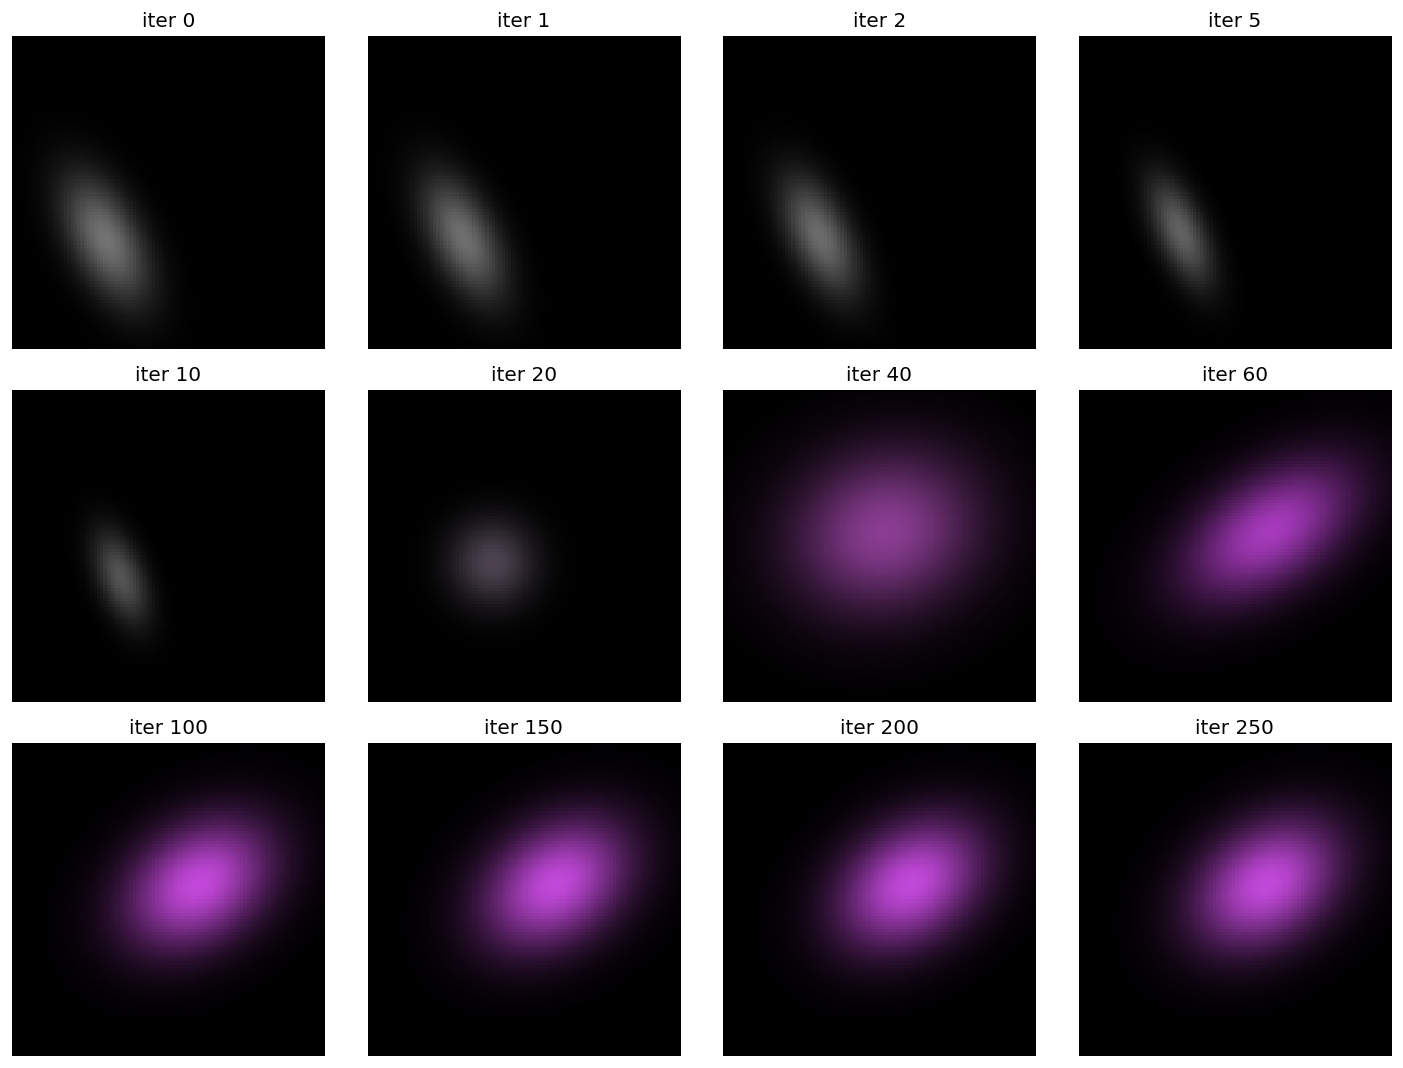

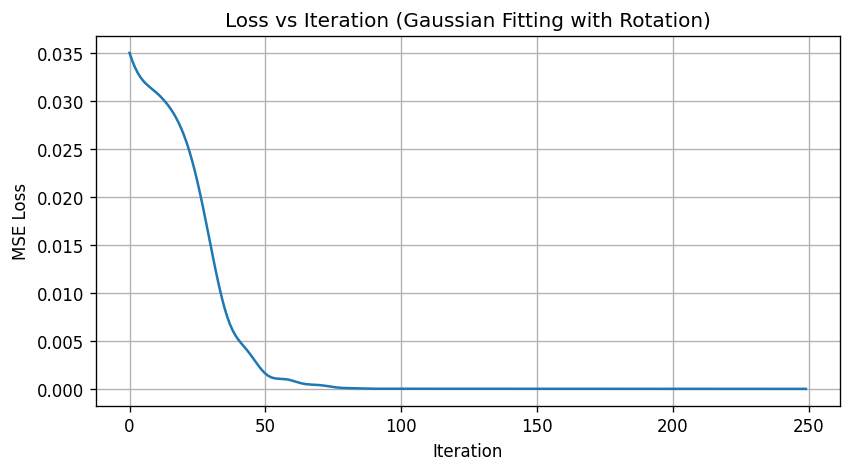

=== Optimization Results (Gaussian with Full Covariance) ===
Initial loss: 0.035010
Final loss: 0.000000
Improvement: 100.00%

Full 2×2 covariance with rotation: Σ^{-1} = R @ diag(1/σ²) @ R^T
Smooth, differentiable optimization of position, scale, rotation, and color!


In [7]:
# Show training snapshots
seen = set()
snapshots_g_unique = []
for snapshot in snapshots_g:
    it = snapshot[0]
    if it not in seen:
        snapshots_g_unique.append(snapshot)
        seen.add(it)
snapshots_g_unique.sort(key=lambda t: t[0])

snap_imgs = []
snap_titles = []
for snapshot in snapshots_g_unique:
    it, mu, sigma, theta, opacity, rgb = snapshot
    snap_imgs.append(render_gaussians_2d(H, W, mu, sigma, theta, opacity, rgb))
    snap_titles.append(f"iter {it}")
show_image_grid(snap_imgs, snap_titles, cols=4, cell_size=3.0)

# Loss curve
plt.figure(figsize=(8, 4))
plt.plot(history_g)
plt.title("Loss vs Iteration (Gaussian Fitting with Rotation)")
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()

print("=== Optimization Results (Gaussian with Full Covariance) ===")
print(f"Initial loss: {history_g[0]:.6f}")
print(f"Final loss: {history_g[-1]:.6f}")
print(f"Improvement: {(1 - history_g[-1]/history_g[0]) * 100:.2f}%")
print("\nFull 2×2 covariance with rotation: Σ^{-1} = R @ diag(1/σ²) @ R^T")
print("Smooth, differentiable optimization of position, scale, rotation, and color!")

## Example 2 — Triangle Fitting with Multiple Gaussian Splats

**Problem**: Use multiple Gaussian splats to approximate a triangle shape.

This demonstrates:
1. **Representation flexibility**: Gaussians can approximate other shapes
2. **Multi-primitive optimization**: Optimizing many Gaussians simultaneously
3. **Additive blending with separate opacity and color**: $I(\mathbf{p}) = \sum_{i=1}^{N} \alpha_i \cdot \text{rgb}_i \cdot f_i(\mathbf{p})$

**Challenge**: Triangles have hard edges, while Gaussians are smooth. We'll see how multiple Gaussians can work together to approximate sharp features.

In [8]:
# Helper function for triangle rendering (from 0202)
def edge_function(a, b, p):
    return (b[..., 0] - a[..., 0]) * (p[..., 1] - a[..., 1]) - (b[..., 1] - a[..., 1]) * (p[..., 0] - a[..., 0])

def barycentric_weights(v0, v1, v2, p):
    area = edge_function(v0, v1, v2)
    area = torch.where(torch.abs(area) < 1e-12, torch.tensor(1e-12, device=area.device), area)
    w0 = edge_function(v1, v2, p) / area
    w1 = edge_function(v2, v0, p) / area
    w2 = edge_function(v0, v1, p) / area
    return w0, w1, w2

def render_triangle_hard(H, W, verts, colors, background=(0.0, 0.0, 0.0)):
    """Hard-edge triangle rasterizer."""
    device = verts.device
    P = make_pixel_grid(H, W, device=device)
    v0, v1, v2 = verts[0], verts[1], verts[2]
    area = edge_function(v0, v1, v2)
    s = 1.0 if area >= 0 else -1.0
    e0 = s * edge_function(v0, v1, P)
    e1 = s * edge_function(v1, v2, P)
    e2 = s * edge_function(v2, v0, P)
    inside = (e0 >= 0) & (e1 >= 0) & (e2 >= 0)
    w0, w1, w2 = barycentric_weights(v0, v1, v2, P)
    rgb = (w0[..., None] * colors[0] + w1[..., None] * colors[1] + w2[..., None] * colors[2])
    rgb = torch.clamp(rgb, 0.0, 1.0)
    img = torch.zeros((H, W, 3), device=device, dtype=verts.dtype)
    img[...] = torch.tensor(background, device=device, dtype=verts.dtype)
    img[inside] = rgb[inside]
    return img

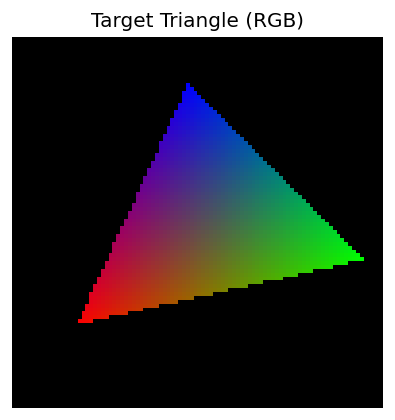

In [9]:
# Create target triangle
verts_target = torch.tensor([
    [-0.65, -0.55],
    [ 0.90, -0.20],
    [-0.05,  0.75],
], dtype=torch.float32)

colors_target = torch.tensor([
    [1.0, 0.0, 0.0],  # Red
    [0.0, 1.0, 0.0],  # Green
    [0.0, 0.0, 1.0],  # Blue
], dtype=torch.float32)

img_target_tri = render_triangle_hard(H, W, verts_target, colors_target)
show_images([img_target_tri], ["Target Triangle (RGB)"])

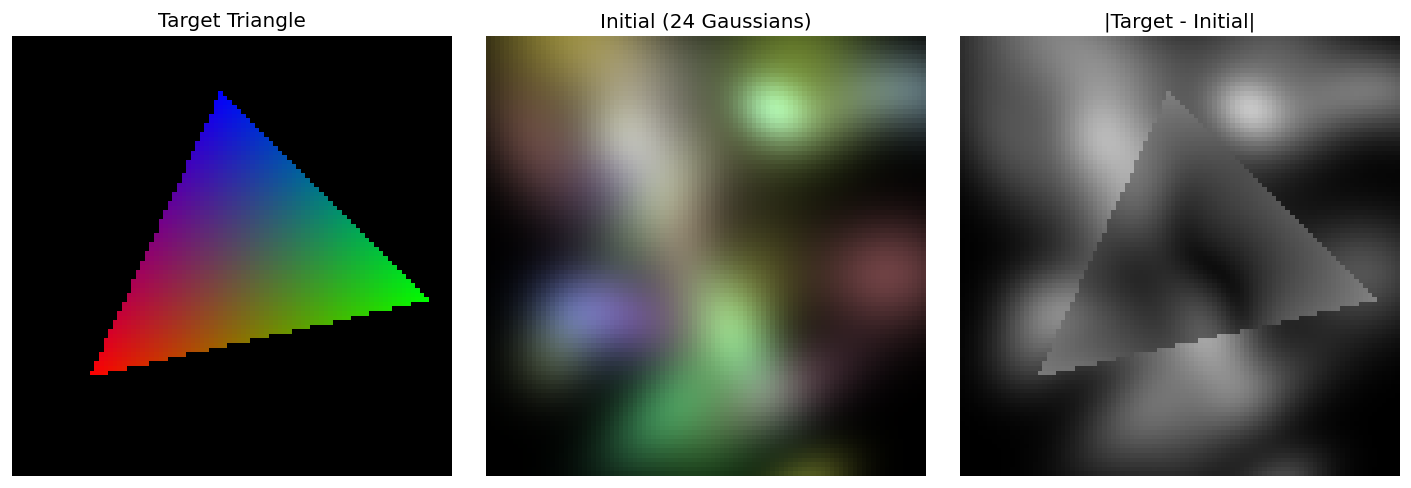

In [10]:
# Initialize multiple random Gaussians to fit the triangle
num_gaussians = 24  # Use multiple Gaussians to approximate the triangle

# Random initialization
torch.manual_seed(42)
init_mus = torch.randn(num_gaussians, 2) * 0.5
init_sigmas = torch.rand(num_gaussians, 2) * 0.2 + 0.1  # Random sizes
init_thetas = torch.rand(num_gaussians) * 2 * np.pi  # Random rotations [0, 2π]
init_opacities = torch.rand(num_gaussians) * 0.5 + 0.3  # Random opacities [0.3, 0.8]
init_rgbs = torch.rand(num_gaussians, 3) * 0.6 + 0.2  # Random RGB colors

img_init_tri = render_gaussians_2d(H, W, init_mus, init_sigmas, init_thetas, init_opacities, init_rgbs)
d_rgb_tri, d_mag_tri = diff_image(img_init_tri, img_target_tri)
show_images(
    [img_target_tri, img_init_tri, d_mag_tri],
    ["Target Triangle", f"Initial ({num_gaussians} Gaussians)", "|Target - Initial|"],
    figsize=(12, 4)
)

In [11]:
# Optimize multiple Gaussians to fit the triangle - now with rotation!
mus_param = init_mus.clone().detach().requires_grad_(True)
sigmas_param = init_sigmas.clone().detach().requires_grad_(True)
thetas_param = init_thetas.clone().detach().requires_grad_(True)
opacities_param = init_opacities.clone().detach().requires_grad_(True)
rgbs_param = init_rgbs.clone().detach().requires_grad_(True)

optimizer_tri = torch.optim.Adam([mus_param, sigmas_param, thetas_param, opacities_param, rgbs_param], lr=0.01)

history_tri = []
snapshots_tri = []
snapshot_schedule_tri = {0, 1, 2, 5, 10, 20, 40, 80, 120, 160, 200, 250, 300, 350}

# Video frames
video_frames_tri = []
video_sample_rate = 3

# Snapshot initial state
snapshots_tri.append((0, mus_param.detach().clone(), sigmas_param.detach().clone(),
                     thetas_param.detach().clone(), opacities_param.detach().clone(), rgbs_param.detach().clone()))
video_frames_tri.append(img_init_tri.detach().cpu().numpy())

max_iters_tri = 350
print(f"Optimizing {num_gaussians} Gaussians (with rotation) to fit triangle...")
for it in range(max_iters_tri):
    optimizer_tri.zero_grad()
    
    # Clamp parameters to valid ranges
    with torch.no_grad():
        mus_param.clamp_(-1.5, 1.5)
        sigmas_param.clamp_(0.01, 1.0)
        opacities_param.clamp_(0.0, 1.0)
        rgbs_param.clamp_(0.0, 1.0)
        # No clamping for thetas - let them rotate freely
    
    # Render all Gaussians and compute loss
    img = render_gaussians_2d(H, W, mus_param, sigmas_param, thetas_param, opacities_param, rgbs_param)
    loss = torch.mean((img - img_target_tri) ** 2)
    
    # Backward pass
    loss.backward()
    optimizer_tri.step()
    
    # Record history
    history_tri.append(loss.item())
    
    # Take snapshots
    if (it + 1) in snapshot_schedule_tri:
        snapshots_tri.append((it + 1, mus_param.detach().clone(), sigmas_param.detach().clone(),
                             thetas_param.detach().clone(), opacities_param.detach().clone(), rgbs_param.detach().clone()))
    
    # Capture video frames
    if (it + 1) % video_sample_rate == 0:
        frame = render_gaussians_2d(H, W, mus_param, sigmas_param, thetas_param, opacities_param, rgbs_param).detach().cpu().numpy()
        video_frames_tri.append(frame)
    
    if (it + 1) % 50 == 0:
        print(f"Iteration {it+1}/{max_iters_tri}, Loss: {loss.item():.6f}")

# Add final frame
final_frame = render_gaussians_2d(H, W, mus_param, sigmas_param, thetas_param, opacities_param, rgbs_param).detach().cpu().numpy()
video_frames_tri.append(final_frame)


print(f"Final loss: {history_tri[-1]:.6f}")
print(f"Trained {num_gaussians} Gaussians to approximate triangle")

Optimizing 24 Gaussians (with rotation) to fit triangle...
Iteration 50/350, Loss: 0.007251
Iteration 100/350, Loss: 0.004338
Iteration 150/350, Loss: 0.003584
Iteration 200/350, Loss: 0.003286
Iteration 250/350, Loss: 0.003167
Iteration 300/350, Loss: 0.002972
Iteration 350/350, Loss: 0.002832
Final loss: 0.002832
Trained 24 Gaussians to approximate triangle


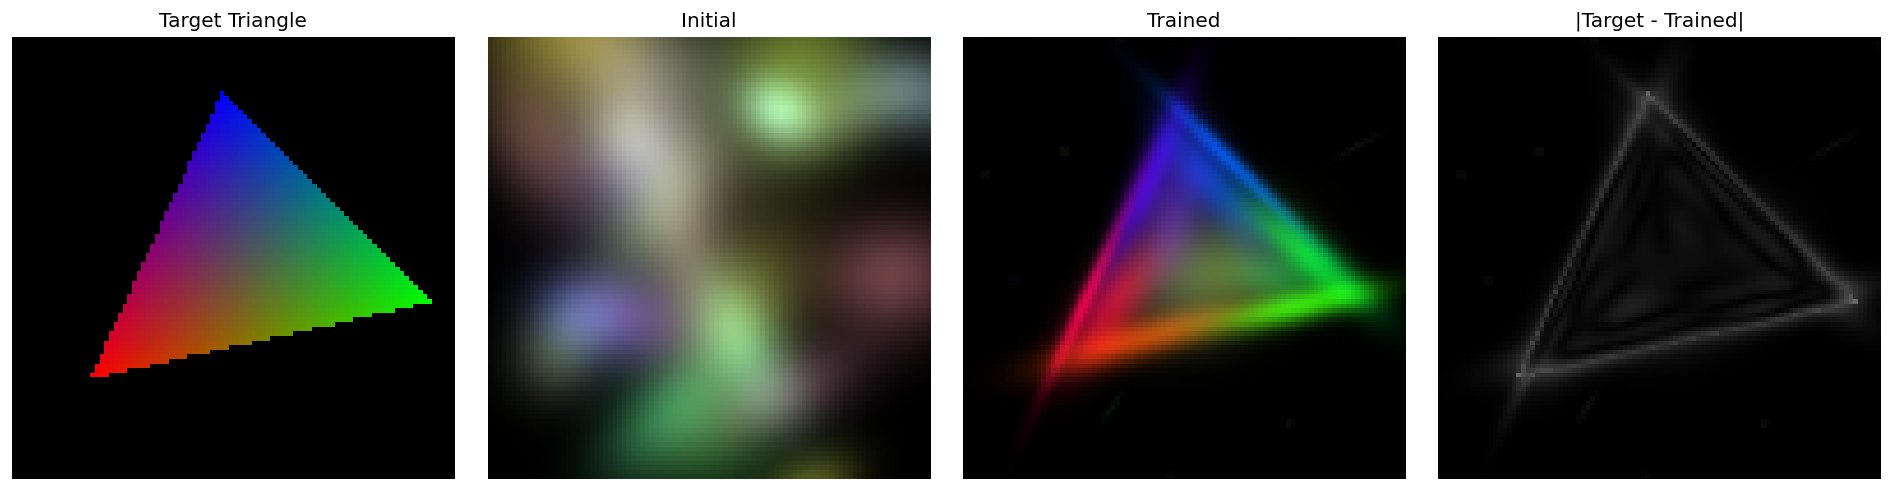

In [12]:
# Final result visualization
img_trained_tri = render_gaussians_2d(H, W, mus_param, sigmas_param, thetas_param, opacities_param, rgbs_param)
d_rgb_t, d_mag_t = diff_image(img_target_tri, img_trained_tri)

show_images(
    [img_target_tri, img_init_tri, img_trained_tri, d_mag_t],
    ["Target Triangle", "Initial", "Trained", "|Target - Trained|"],
    figsize=(16, 4)
)

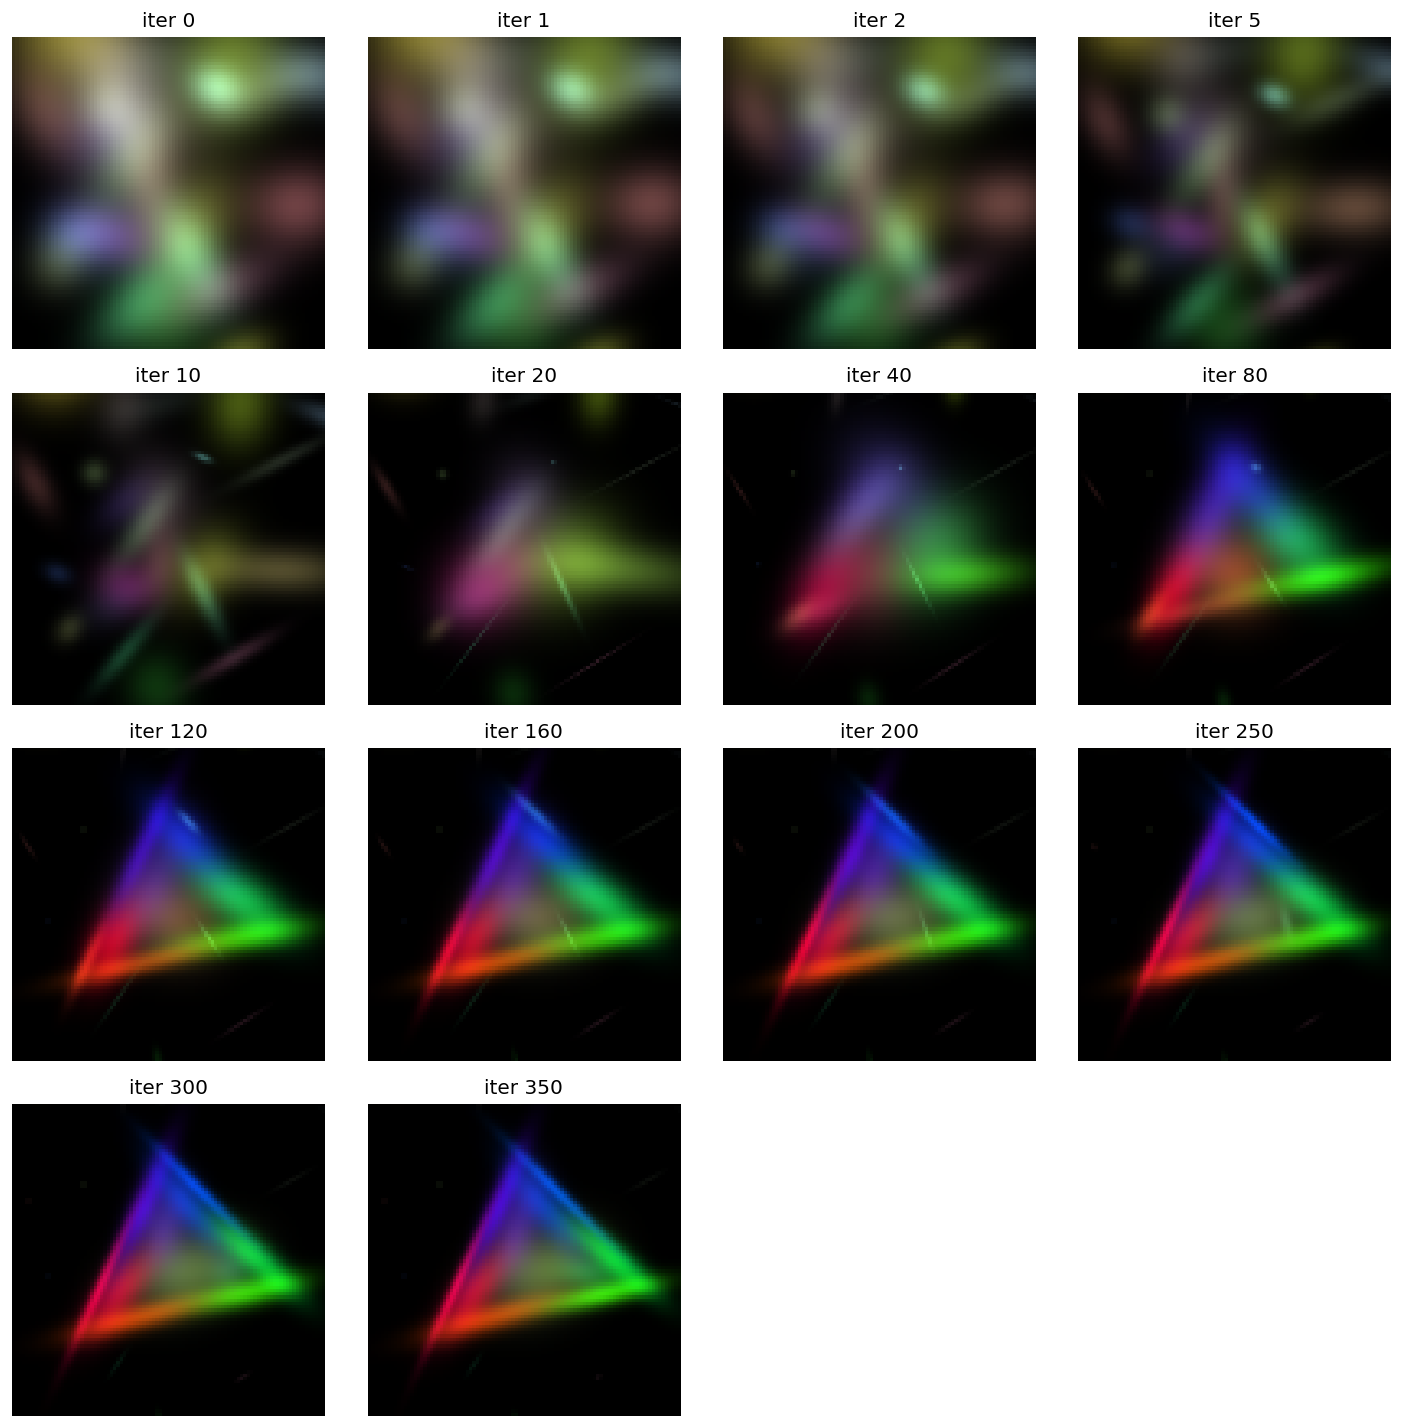

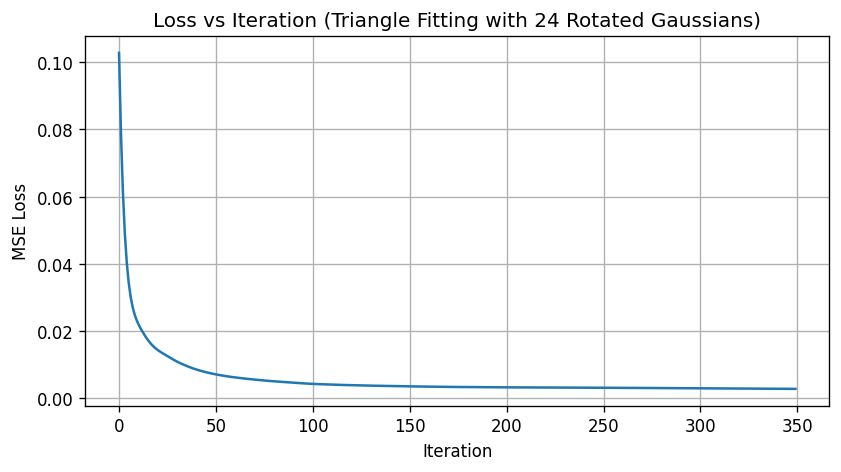

=== Optimization Results (Triangle Fitting with Rotation) ===
Number of Gaussians: 24
Initial loss: 0.102755
Final loss: 0.002832
Improvement: 97.24%
Key insight: Rotated Gaussians can better approximate oriented features!
Full 2×2 covariance matrices allow alignment with triangle edges.


In [13]:
# Show training snapshots for triangle fitting
seen = set()
snapshots_tri_unique = []
for snapshot in snapshots_tri:
    it = snapshot[0]
    if it not in seen:
        snapshots_tri_unique.append(snapshot)
        seen.add(it)
snapshots_tri_unique.sort(key=lambda t: t[0])

snap_imgs = []
snap_titles = []
for snapshot in snapshots_tri_unique:
    it, mus, sigmas, thetas, opacities, rgbs = snapshot
    snap_imgs.append(render_gaussians_2d(H, W, mus, sigmas, thetas, opacities, rgbs))
    snap_titles.append(f"iter {it}")
show_image_grid(snap_imgs, snap_titles, cols=4, cell_size=3.0)

# Loss curve
plt.figure(figsize=(8, 4))
plt.plot(history_tri)
plt.title(f"Loss vs Iteration (Triangle Fitting with {num_gaussians} Rotated Gaussians)")
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()

print("=== Optimization Results (Triangle Fitting with Rotation) ===")
print(f"Number of Gaussians: {num_gaussians}")
print(f"Initial loss: {history_tri[0]:.6f}")
print(f"Final loss: {history_tri[-1]:.6f}")
print(f"Improvement: {(1 - history_tri[-1]/history_tri[0]) * 100:.2f}%")

print("Key insight: Rotated Gaussians can better approximate oriented features!")
print("Full 2×2 covariance matrices allow alignment with triangle edges.")

In [14]:
# Save and display training video for triangle fitting
print(f"Creating video with {len(video_frames_tri)} frames...")
save_training_video(video_frames_tri, "gaussian_triangle_training.mp4", fps=30, 
                   title=f"Triangle Fitting with {num_gaussians} Gaussians")
Video("gaussian_triangle_training.mp4", embed=True, width=600)

Creating video with 118 frames...
Video saved to gaussian_triangle_training.mp4


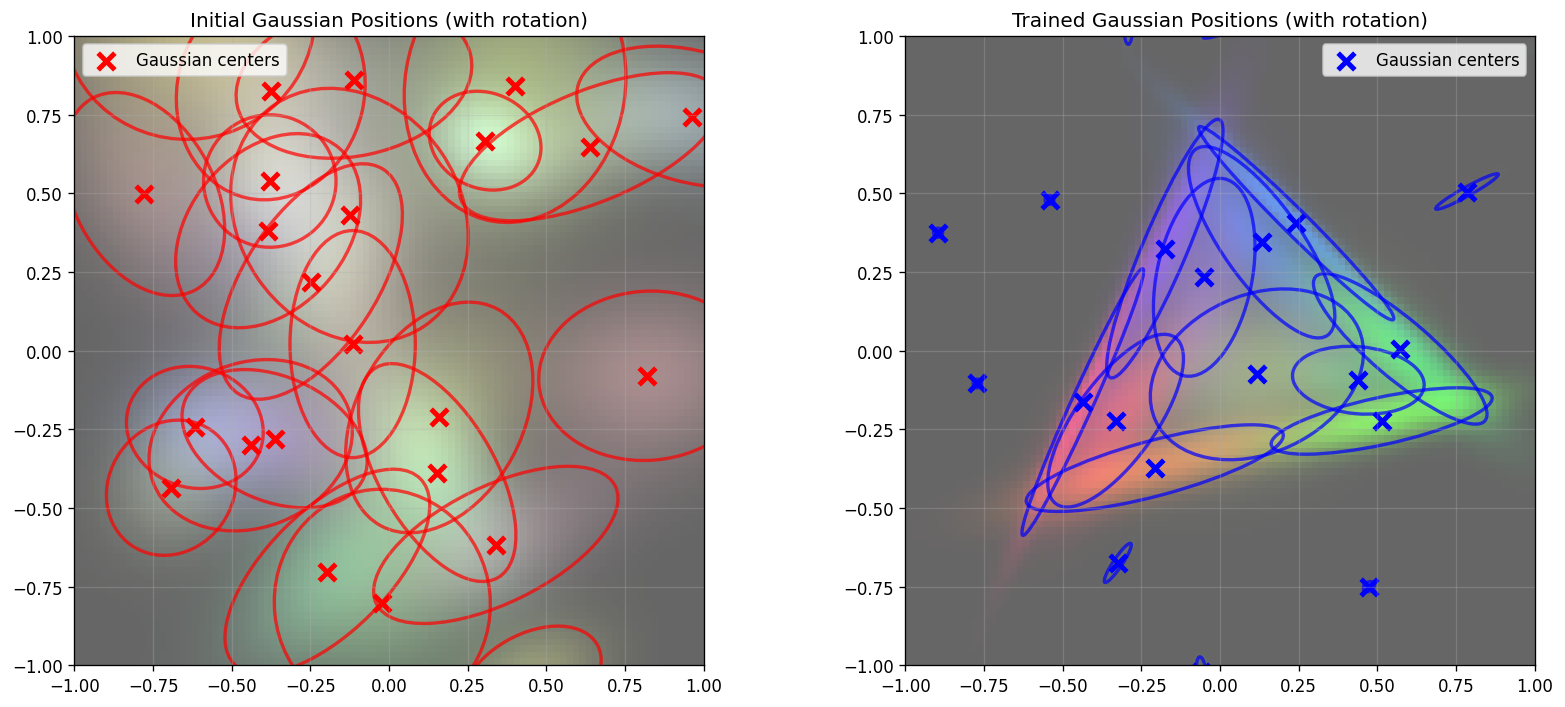

Notice how the Gaussians:
• Moved to concentrate around the triangle edges
• Adjusted their sizes to better cover the target shape
• Rotated to align with the triangle's oriented edges
• Changed colors to match the target RGB distribution


In [15]:
# Visualize Gaussian positions and their evolution with rotation
from matplotlib.patches import Ellipse

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Initial positions
mus_np = init_mus.detach().cpu().numpy()
ax1.imshow(img_init_tri.detach().cpu().numpy(), extent=[-1, 1, -1, 1], origin='upper', alpha=0.6)
ax1.scatter(mus_np[:, 0], mus_np[:, 1], c='red', s=100, marker='x', linewidths=3, label='Gaussian centers')
for i in range(num_gaussians):
    ellipse = Ellipse(
        (mus_np[i, 0], mus_np[i, 1]),
        width=init_sigmas[i, 0].item() * 3,
        height=init_sigmas[i, 1].item() * 3,
        angle=np.degrees(init_thetas[i].item()),  # Convert radians to degrees
        edgecolor='red',
        facecolor='none',
        linewidth=2,
        alpha=0.7
    )
    ax1.add_patch(ellipse)
ax1.set_xlim(-1, 1)
ax1.set_ylim(-1, 1)
ax1.set_aspect('equal')
ax1.set_title('Initial Gaussian Positions (with rotation)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Final positions
mus_np = mus_param.detach().cpu().numpy()
ax2.imshow(img_trained_tri.detach().cpu().numpy(), extent=[-1, 1, -1, 1], origin='upper', alpha=0.6)
ax2.scatter(mus_np[:, 0], mus_np[:, 1], c='blue', s=100, marker='x', linewidths=3, label='Gaussian centers')
for i in range(num_gaussians):
    ellipse = Ellipse(
        (mus_np[i, 0], mus_np[i, 1]),
        width=sigmas_param[i, 0].item() * 3,
        height=sigmas_param[i, 1].item() * 3,
        angle=np.degrees(thetas_param[i].item()),  # Convert radians to degrees
        edgecolor='blue',
        facecolor='none',
        linewidth=2,
        alpha=0.7
    )
    ax2.add_patch(ellipse)
ax2.set_xlim(-1, 1)
ax2.set_ylim(-1, 1)
ax2.set_aspect('equal')
ax2.set_title('Trained Gaussian Positions (with rotation)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Notice how the Gaussians:")
print("• Moved to concentrate around the triangle edges")
print("• Adjusted their sizes to better cover the target shape")
print("• Rotated to align with the triangle's oriented edges")
print("• Changed colors to match the target RGB distribution")

## 더 생각해볼 것들

- 피팅의 품질을 더 높이려면 어떻게 해야 할까?
- 훈련 속도를 높이려면 어떻게 해야 할까? 특히 반복해서 테스트하는 상황에서 시간과 에너지를 절약하려면 어떻게 해야 할까?

## 참고자료 (References)

**3D Gaussian Splatting for Real-Time Radiance Field Rendering (2023)**
- Kerbl et al., SIGGRAPH 2023
- [Paper](https://arxiv.org/abs/2308.04079) | [Project Page](https://repo-sam.inria.fr/fungraph/3d-gaussian-splatting/)
- Introduced Gaussian splatting for 3D scene representation

**tiny-2d-gaussian-splatting**
- [GitHub Repository](https://github.com/bobarna/tiny-2d-gaussian-splatting)
- Minimal implementation of 2D Gaussian Splatting with PyTorch
- Educational resource for understanding core concepts

**2D-Gaussian-Splatting (OutofAi)**
- [GitHub Repository](https://github.com/OutofAi/2D-Gaussian-Splatting)
- 2D Gaussian Splatting implementation with image reconstruction examples

**Gaussian-Splatting-2D**
- [GitHub Repository](https://github.com/aoru45/Gaussian-Splatting-2D)
- Python implementation exploring 2D Gaussian representations

### Key Concepts

**Advantages of Gaussian Splatting**:
1. **Smooth gradients**: Gaussians are differentiable everywhere
2. **Flexible representation**: Can approximate various shapes
3. **Easy optimization**: Works well with gradient descent
4. **Smooth blending**: In this notebook we use additive accumulation; full 3DGS commonly uses depth-sorted alpha compositing

**Comparison with Triangles**:
- Triangles: Hard edges → difficult optimization
- Gaussians: Soft everywhere → excellent gradients
- Trade-off: Gaussians less precise for sharp features, but much easier to optimize